In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import missingno as msno

In [68]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

# 데이터 경로 맞춰주세요!
# 혹시 코랩환경을 사용하신다면 왼쪽 폴더모양 아이콘을 눌러 "train_data.csv"를 드래그&드롭으로 업로드한 후 사용해주세요
DATA_PATH = './data/train_data.csv'
df = pd.read_csv(DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

CPU times: user 4.26 s, sys: 340 ms, total: 4.6 s
Wall time: 4.63 s


## 기본 정보 파악

In [69]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2266586 entries, 0 to 2266585
Data columns (total 6 columns):
 #   Column            Dtype         
---  ------            -----         
 0   userID            int16         
 1   assessmentItemID  object        
 2   testId            object        
 3   answerCode        int8          
 4   Timestamp         datetime64[ns]
 5   KnowledgeTag      int16         
dtypes: datetime64[ns](1), int16(2), int8(1), object(2)
memory usage: 62.7+ MB


In [71]:
print(f"""--- BASIC INFORMATIONS ---
userID           : {df.userID.nunique()}
assessmentItemID : {df.assessmentItemID.nunique()}
testID           : {df.testId.nunique()}
mean answer rate : {df.answerCode.sum() / df.shape[0] * 100:.2f}%
KnowledgeTag     : {df.KnowledgeTag.nunique()}
{'-'*26}""")

--- BASIC INFORMATIONS ---
userID           : 6698
assessmentItemID : 9454
testID           : 1537
mean answer rate : 65.44%
KnowledgeTag     : 912
--------------------------


+ `userID`(int16) : 사용자의 고유 번호입니다. 총 6698명의 학생이 있습니다.   
+ `assessmentItemID`(object) : 사용자가 푼 문항의 일련 번호입니다.   
+ `testId`(object) : 사용자가 푼 문항이 포함된 시험지의 일련 번호입니다.   
+ `answerCode`(int8) : 사용자가 푼 문항의 정답 여부를 담고 있는 이진 (0/1) 데이터입니다.   
+ `Timestamp`(datetime64[ns]) : 사용자가 문항을 푼 시간 정보입니다.   
+ `KnowledgeTag`(int16) : 사용자가 푼 문항의 고유 태그가 담겨져 있습니다.   
특성 별로 자세히 살펴봅시다.

## 기본적인 전처리

In [72]:
# 문제 풀이에 소요한 시간추가
diff_train = df.loc[:, ['userID','Timestamp']].groupby('userID').diff().shift(-1)
diff_train = diff_train['Timestamp'].apply(lambda x : x.total_seconds())
df['elapsed'] = diff_train

df.groupby('userID').apply(lambda x :x.iloc[:-1])

# 한 시간이 지나면 outlier로 처리
outlier = 1*3600
non_outlier = df[df['elapsed'] <= outlier]
# outlier에 해당하지 않는 row로 재구성 한 후 각 태그의 평균처리
mean_elapsed = non_outlier.groupby('KnowledgeTag')['elapsed'].mean()
df.loc[df['elapsed'] > outlier, 'elapsed'] = df[df['elapsed'] > outlier].apply(lambda x: mean_elapsed.get(x['KnowledgeTag'], x['elapsed']), axis=1)

In [78]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,3.000000
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,8.000000
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,7.000000
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.000000
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,11.000000
...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,96.586217
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,11.000000
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,46.000000
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,73.000000


## 이상치

In [79]:
def percentile(s):
    return np.sum(s) / len(s)

### 정답률이 너무 높거나 낮은 유저
- 정답률이 1인 유저는 문제풀이 수 q1의 값인 78문제 보다 적으므로 제외하는 것이 맞다는 판단
- 정답률이 0인 유저도 푼 문제 수가 16문제로 제외하는 것이 맞다는 판단

In [80]:
stu_groupby = df.groupby('userID').agg({
    'assessmentItemID' : 'count',
    'answerCode' : percentile
})

/opt/conda/envs/eda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


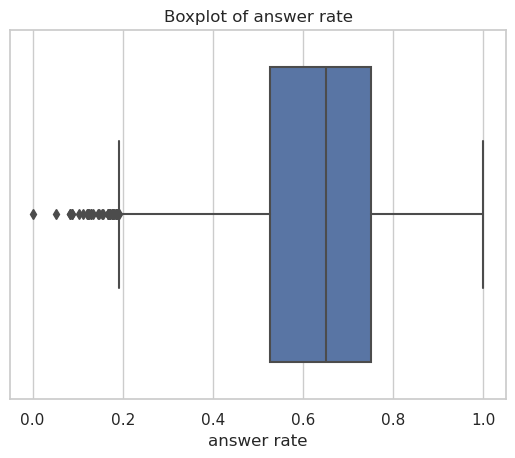

In [81]:
sns.set(style="whitegrid")
sns.boxplot(x=stu_groupby['answerCode'])

plt.title('Boxplot of answer rate')
plt.xlabel('answer rate')
plt.show()

In [82]:
stu_groupby['answerCode'].describe(percentiles=[.25, .50, .75])

count    6698.000000
mean        0.628909
std         0.159639
min         0.000000
25%         0.527273
50%         0.651757
75%         0.751203
max         1.000000
Name: answerCode, dtype: float64

In [83]:
quartiles = np.percentile(stu_groupby['answerCode'], [25, 50, 75])
lower_q1 = len(stu_groupby.loc[stu_groupby['answerCode']<quartiles[0] - 1.5*(quartiles[2] - quartiles[0])])
upper_q3 = len(stu_groupby.loc[stu_groupby['answerCode']>quartiles[2] + 1.5*(quartiles[2] - quartiles[0])])

## 4분위표 기준
print("정답륭이 낮은 인원 수: ",lower_q1)
print("정답률이 높은 인원 수: ",upper_q3)

정답륭이 낮은 인원 수:  38
정답률이 높은 인원 수:  0


In [84]:
### 정답률이 1인 유저
Ans = len(stu_groupby.loc[stu_groupby['answerCode'] == 1])
print("정답률이 1인 유저 수: ",Ans)

정답률이 1인 유저 수:  2


In [85]:
### 정답률이 0인 유저
Ans = len(stu_groupby.loc[stu_groupby['answerCode'] == 0])
print("정답률이 0인 유저 수: ",Ans)

정답률이 0인 유저 수:  1


In [86]:
print("정답률이 1인 유저 2명 중 6988번 유저의 문제풀이 수: ", end="")
print(len(df.loc[df['userID'].isin(list(stu_groupby.loc[stu_groupby['answerCode'] == 1].index)) & (df['userID']==6988)]))

정답률이 1인 유저 2명 중 6988번 유저의 문제풀이 수: 23


In [87]:
print("정답률이 1인 유저 2명 중 7171번 유저의 문제풀이 수: ", end="")
print(len(df.loc[df['userID'].isin(list(stu_groupby.loc[stu_groupby['answerCode'] == 1].index)) & (df['userID']==7171)]))

정답률이 1인 유저 2명 중 7171번 유저의 문제풀이 수: 20


In [88]:
print("정답률이 0인 유저 2명 중 6988번 유저의 문제풀이 수: ", end="")
print(len(df.loc[df['userID'].isin(list(stu_groupby.loc[stu_groupby['answerCode'] == 0].index))]))

정답률이 0인 유저 2명 중 6988번 유저의 문제풀이 수: 16


### 정답률이 너무 높거나 낮은 문제
- 정답률이 1이거나 0인 경우는 발견하지 못함
- 정답률이 제일 낮은 문제는 문제를 푼 사람 수가 적은 원인이 아니라 outlier로 볼 수 없음
- 정답률이 제일 높은 문제도 마찬가지

In [89]:
prob_groupby = df.groupby('assessmentItemID').agg({
    'userID': 'count',
    'answerCode': percentile
})

/opt/conda/envs/eda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


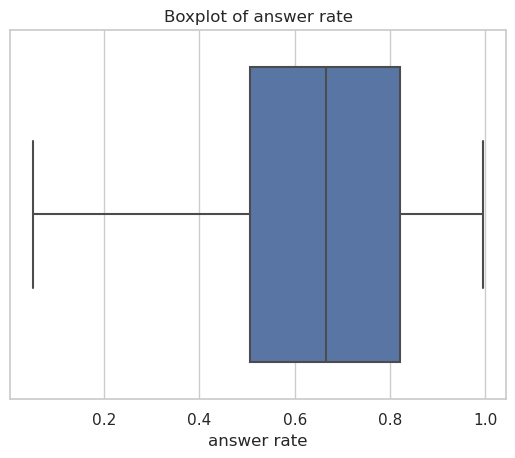

In [117]:
sns.set(style="whitegrid")
sns.boxplot(x=prob_groupby['answerCode'])

plt.title('Boxplot of answer rate')
plt.xlabel('answer rate')
plt.show()

In [118]:
prob_groupby['answerCode'].describe(percentiles=[.25, .50, .75])

count    9454.000000
mean        0.654256
std         0.195488
min         0.049430
25%         0.505548
50%         0.666667
75%         0.820513
max         0.996310
Name: answerCode, dtype: float64

In [119]:
quartiles = np.percentile(prob_groupby['answerCode'], [25, 50, 75])
lower_q1 = len(prob_groupby.loc[prob_groupby['answerCode']<quartiles[0] - 1.5*(quartiles[2] - quartiles[0])])
upper_q3 = len(prob_groupby.loc[prob_groupby['answerCode']>quartiles[2] + 1.5*(quartiles[2] - quartiles[0])])

## 4분위표 기준
print("정답륭이 낮은 문제 수: ",lower_q1)
print("정답률이 높은 문제 수: ",upper_q3)

정답륭이 낮은 문제 수:  0
정답률이 높은 문제 수:  0


In [122]:
prob_groupby.loc[prob_groupby['answerCode'] == prob_groupby['answerCode'].min()]

,userID,answerCode
assessmentItemID,,
A040131005,263,0.04943


In [123]:
prob_groupby.loc[prob_groupby['answerCode'] == prob_groupby['answerCode'].max()]

,userID,answerCode
assessmentItemID,,
A020080003,271,0.99631


### 정답률이 너무 높거나 낮은 시험지
- 정답률이 높은 시험지는 문제 수가 적고 시험 응시자가 적을 것이라 판단. 
- 하지만 전체 시험지 문제 수 분포를 봤을 때 문제 수가 적지도 않고 응시자도 적지 않음
- 정답률이 낮은 시험지도 마찬가지로 outlier가 아님을 확인

In [90]:
test_groupby = df.groupby('testId').agg({
    'userID': 'count',
    'answerCode': percentile
})

/opt/conda/envs/eda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


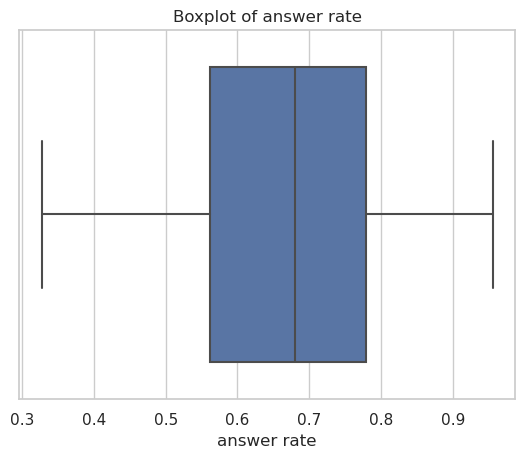

In [91]:
sns.set(style="whitegrid")
sns.boxplot(x=test_groupby['answerCode'])

plt.title('Boxplot of answer rate')
plt.xlabel('answer rate')
plt.show()

In [92]:
test_groupby['answerCode'].describe(percentiles=[.25, .50, .75])

count    1537.000000
mean        0.667982
std         0.138903
min         0.327186
25%         0.561819
50%         0.680519
75%         0.778439
max         0.955474
Name: answerCode, dtype: float64

In [93]:
quartiles = np.percentile(test_groupby['answerCode'], [25, 50, 75])
lower_q1 = len(test_groupby.loc[test_groupby['answerCode']<quartiles[0] - 1.5*(quartiles[2] - quartiles[0])])
upper_q3 = len(test_groupby.loc[test_groupby['answerCode']>quartiles[2] + 1.5*(quartiles[2] - quartiles[0])])

## 4분위표 기준
print("정답륭이 낮은 시험지 수: ",lower_q1)
print("정답률이 높은 시험지 수: ",upper_q3)

정답륭이 낮은 시험지 수:  0
정답률이 높은 시험지 수:  0


In [94]:
# 정답률이 최솟값인 testId에 대한 응시자 수와 정답률
test_groupby.loc[test_groupby['answerCode'] == test_groupby['answerCode'].min()]

,userID,answerCode
testId,,
A090000035,1464,0.327186


In [95]:
# 정답률이 최소인 testId 문항 수
min_answer_rate_prob = df.loc[df['testId'].isin(test_groupby.loc[test_groupby['answerCode'] == test_groupby['answerCode'].min()].index)].groupby('userID').count()['assessmentItemID']
min_answer_rate_prob.unique()

array([ 8, 16])

In [96]:
# 정답률이 최댓값인 testId에 대한 응시자 수와 정답률
test_groupby.loc[test_groupby['answerCode'] == test_groupby['answerCode'].max()]

,userID,answerCode
testId,,
A040000187,1370,0.955474


In [97]:
# 정답률이 최대인 testId 문항 수
max_answer_rate_prob = df.loc[df['testId'].isin(test_groupby.loc[test_groupby['answerCode'] == test_groupby['answerCode'].max()].index)].groupby('userID').count()['assessmentItemID']
max_answer_rate_prob[max_answer_rate_prob == 10]

userID
174     10
3677    10
Name: assessmentItemID, dtype: int64

In [108]:
test_groupby_item = df.groupby(['userID','testId']).agg({
    'userID': 'count',
    'assessmentItemID': 'count'
})
test_groupby_item.describe()

,userID,assessmentItemID
count,365164.000000,365164.000000
mean,6.207036,6.207036
std,1.712452,1.712452
min,2.000000,2.000000
25%,5.000000,5.000000
50%,6.000000,6.000000
75%,7.000000,7.000000
max,27.000000,27.000000


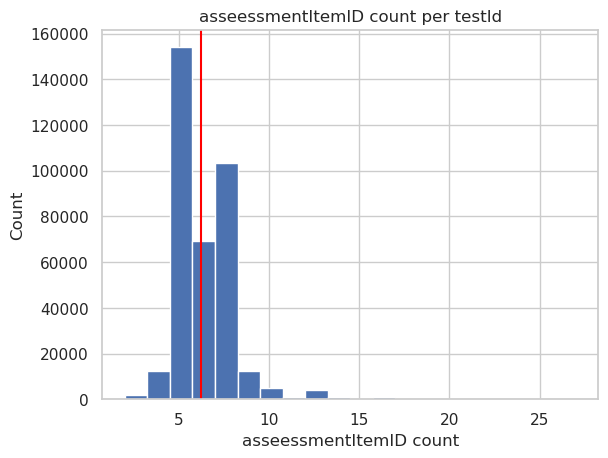

In [101]:
## 시험지 별 문항 수 분포
fig, ax = plt.subplots()
test_groupby_item['assessmentItemID'].hist(bins=20)
ax.set_title('asseessmentItemID count per testId')
ax.set_xlabel('asseessmentItemID count')
ax.set_ylabel('Count')
ax.axvline(test_groupby_item['assessmentItemID'].mean(), color='red')
ax.grid(visible=True)

In [109]:
test_groupby_user = df.groupby('testId').agg({
    'userID': 'count'
})
test_groupby_user.describe()

,userID
count,1537.000000
mean,1474.681848
std,533.526783
min,172.000000
25%,1320.000000
50%,1400.000000
75%,1602.000000
max,3960.000000


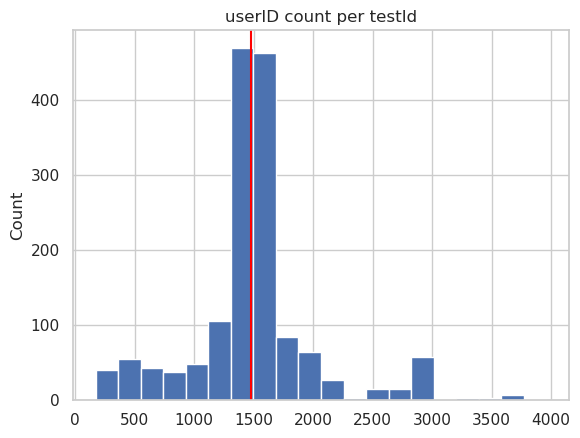

In [106]:
# 시험지 별 응시자 수
test_groupby_user.describe()
fig, ax = plt.subplots()
test_groupby_user['userID'].hist(bins=20)
ax.set_title('userID count per testId')
ax.set_xlabel('')
ax.set_ylabel('Count')
ax.axvline(test_groupby_user['userID'].mean(), color='red')
ax.grid(visible=True)

### 문제풀이 수가 적은 유저

In [110]:
stu_groupby = df.groupby('userID').agg({
    'assessmentItemID' : 'count',
    'answerCode' : percentile
})

/opt/conda/envs/eda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


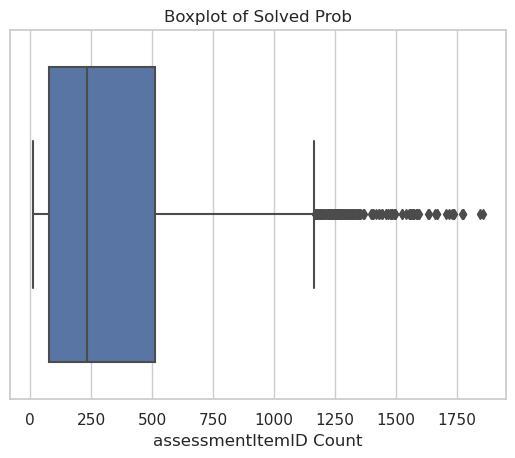

In [111]:
sns.set(style="whitegrid")
sns.boxplot(x=stu_groupby['assessmentItemID'])

plt.title('Boxplot of Solved Prob')
plt.xlabel('assessmentItemID Count')
plt.show()

In [41]:
stu_groupby['assessmentItemID'].describe(percentiles=[.25, .50, .75])

count    6698.000000
mean      338.397432
std       321.331429
min         9.000000
25%        78.000000
50%       231.500000
75%       513.000000
max      1860.000000
Name: assessmentItemID, dtype: float64

### 평균 문제풀이 시간이 너무 긴 문제

In [112]:
assessmentItemID_groupby = df.groupby('assessmentItemID').agg({
    'userID': 'count',
    'elapsed': 'mean'
})

/opt/conda/envs/eda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


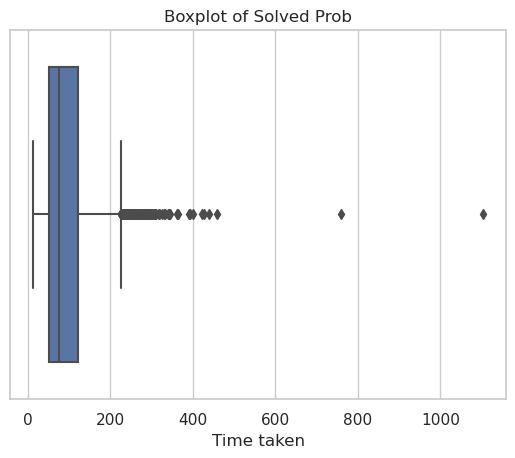

In [113]:
sns.set(style="whitegrid")
sns.boxplot(x=assessmentItemID_groupby['elapsed'])

plt.title('Boxplot of Solved Prob')
plt.xlabel('Time taken')
plt.show()

In [114]:
assessmentItemID_groupby['elapsed'].describe(percentiles=[.25, .50, .75])

count    9454.000000
mean       91.916990
std        57.307061
min        10.932907
25%        50.448748
50%        74.947697
75%       120.642168
max      1104.590909
Name: elapsed, dtype: float64

In [115]:
# 걸린 시간이 가장 긴 문제
max_time_item_idx = assessmentItemID_groupby.loc[assessmentItemID_groupby['elapsed']==assessmentItemID_groupby['elapsed'].max()].index
df.loc[df['assessmentItemID'].isin(max_time_item_idx)]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
36615,49,A030169005,A030000169,1,2020-09-09 14:19:27,1875,33.000000
52239,70,A030169005,A030000169,0,2020-08-25 06:43:20,1875,1104.590909
53208,71,A030169005,A030000169,0,2020-10-18 09:11:16,1875,1104.590909
68549,89,A030169005,A030000169,0,2020-05-29 10:35:03,1875,1104.590909
70697,93,A030169005,A030000169,0,2020-04-22 02:46:16,1875,1104.590909
...,...,...,...,...,...,...,...
2247293,6674,A030169005,A030000169,0,2020-09-10 23:23:15,1875,1104.590909
2253839,6855,A030169005,A030000169,1,2020-10-16 06:21:41,1875,1104.590909
2255009,6888,A030169005,A030000169,0,2020-10-16 02:39:02,1875,1104.590909
2258386,7011,A030169005,A030000169,0,2020-10-15 11:37:05,1875,1104.590909


## 기본적인 EDA

### 정답률 분포

#### 문항 정답률

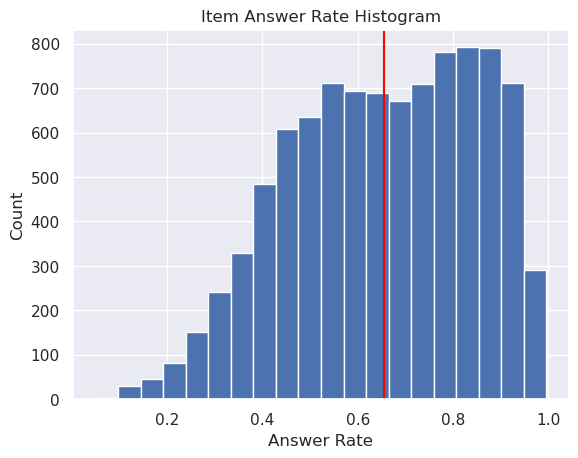

In [8]:
prob_groupby = df.groupby('assessmentItemID').agg({
    'userID': 'count',
    'answerCode': percentile
})

fig, ax = plt.subplots()
prob_groupby['answerCode'].hist(bins=20)
ax.set_title('Item Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(prob_groupby['answerCode'].mean(), color='red')
ax.grid(visible=True)

#### 유저 정답률
FE
- 유저를 9등급으로 나누는 방안

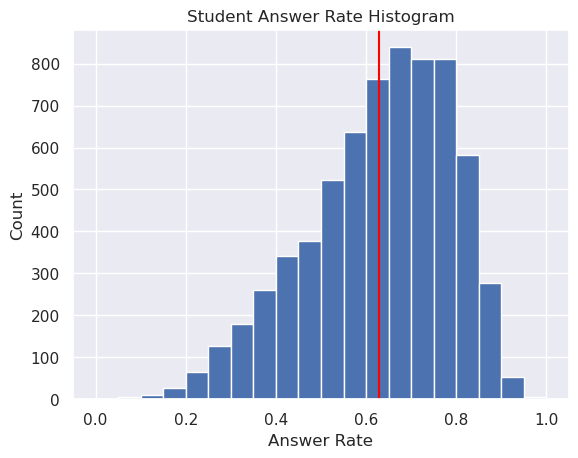

In [9]:
stu_groupby = df.groupby('userID').agg({
    'assessmentItemID' : 'count',
    'answerCode' : percentile
})
fig, ax = plt.subplots()

stu_groupby['answerCode'].hist(bins=20)

ax.set_title('Student Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(stu_groupby['answerCode'].mean(), color='red')
ax.grid(visible=True)

#### 태그 정답률

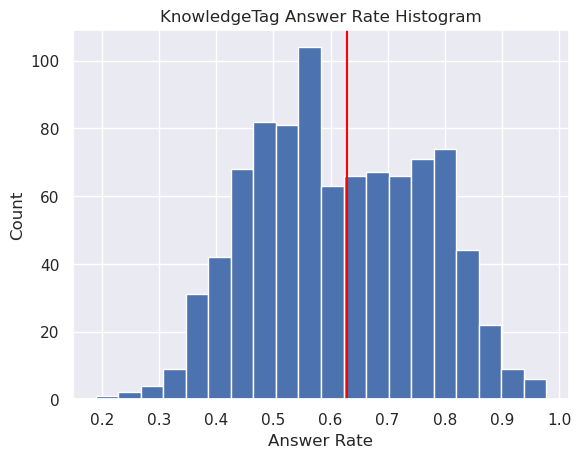

In [10]:
tag_groupby = df.groupby('KnowledgeTag').agg({
    'userID' : 'count',
    'answerCode' : percentile
})

fig, ax = plt.subplots()

tag_groupby['answerCode'].hist(bins=20)

ax.set_title('KnowledgeTag Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(stu_groupby['answerCode'].mean(), color='red')
ax.grid(visible=True)

#### 시험지 정답률

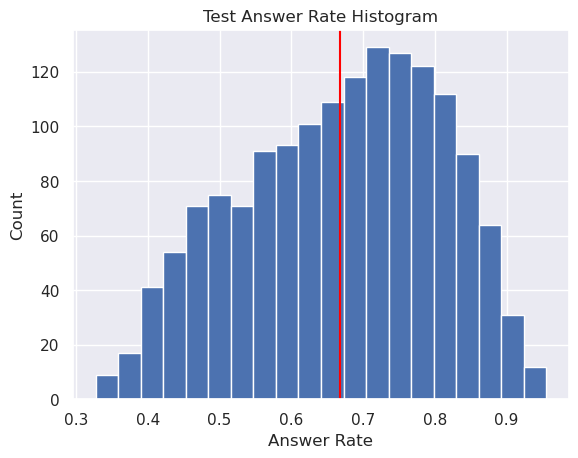

In [11]:
test_groupby = df.groupby('testId').agg({
    'userID': 'count',
    'answerCode': percentile
})
test_groupby.describe()

fig, ax = plt.subplots()
test_groupby['answerCode'].hist(bins=20)
ax.set_title('Test Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(test_groupby['answerCode'].mean(), color='red')
ax.grid(visible=True)

### 소요 시간

#### 문제 풀이시간에 따른 정답률

In [119]:
elapsed_answer = df.groupby('elapsed').agg({'answerCode': percentile, 'userID': 'count'})
elapsed_hist = elapsed_answer[elapsed_answer['userID'] > 100]

(-10.0, 650.0)

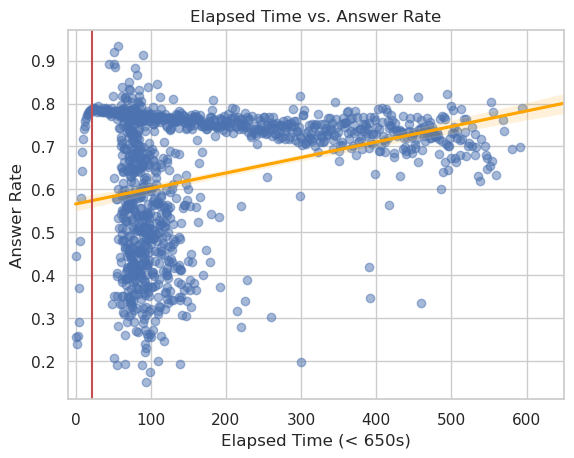

In [120]:
fig, ax = plt.subplots()
g = sns.regplot(x=elapsed_hist.index[:-1], y=elapsed_hist.answerCode.values[:-1],
            scatter_kws={'alpha':0.5}, line_kws={"color": "orange"}, ax=ax)
ax.set_title('Elapsed Time vs. Answer Rate')
ax.set_xlabel('Elapsed Time (< 650s)')
ax.set_ylabel('Answer Rate')
ax.axvline(22, color='r')
ax.set_xlim(-10, 650)

### 유저별 공부에 사용한 총 시간이 길수록 정답률이 올라갈까?
-  상관관계가 0.269 수준으로 유의미한 관계는 없어보임

정답률과 공부한 시간 사이 상관관계: 0.269


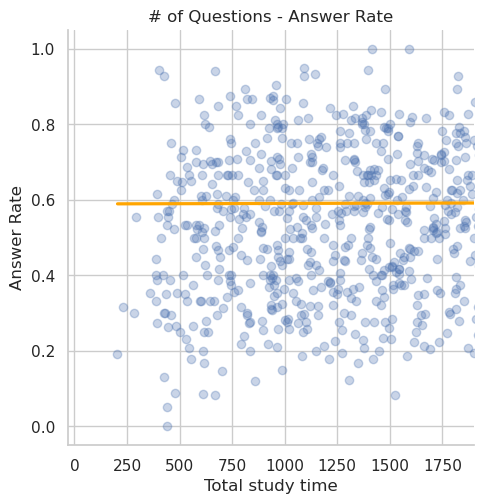

In [127]:
user_elapsed_groupby =df.groupby('userID').agg({
    'elapsed': 'sum',
    'answerCode': percentile
})

g = sns.lmplot(
    data=user_elapsed_groupby,
    x='elapsed',
    y='answerCode',
    scatter_kws={'alpha':0.3},
    line_kws={"color": "orange"}
)
g.set_xlabels('Total study time')
g.set_ylabels('Answer Rate')
g.set(xlim=(-30, 1900))

ax = plt.gca()
ax.set_title('# of Questions - Answer Rate')
print(f"정답률과 공부한 시간 사이 상관관계: {user_elapsed_groupby.corr()['elapsed']['answerCode']:.3f}")

## userID 분석

### 문항을 풀수록 실력이 늘어나는가?
* 거의 관계 없음 (정답률과 문제를 푼 개수 사이 상관관계: 0.168)

정답률과 문제를 푼 개수 사이 상관관계: 0.168


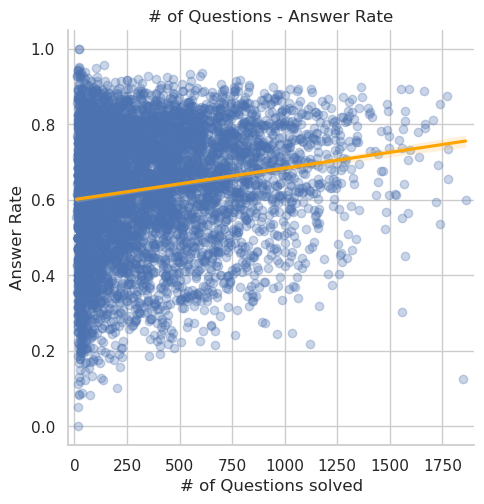

In [122]:
g = sns.lmplot(
    data=stu_groupby,
    x='assessmentItemID',
    y='answerCode',
    scatter_kws={'alpha':0.3},
    line_kws={"color": "orange"}
)
g.set_xlabels('# of Questions solved')
g.set_ylabels('Answer Rate')
g.set(xlim=(-30, 1900))

ax = plt.gca()
ax.set_title('# of Questions - Answer Rate')
print(f"정답률과 문제를 푼 개수 사이 상관관계: {stu_groupby.corr()['assessmentItemID']['answerCode']:.3f}")

## testID 분석

### testID의 3번째 값인 대분류

In [23]:
# 9개의 대분류값이 존재
df['testId'].str[2].nunique()

9

#### 대분류 column 추가

In [24]:
df['main_cate_testID'] = df['testId'].str[2]
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,main_cate_testID
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6
...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,3
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,4
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,4
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,4


### 대분류 별 정답률 분석
- 대분류 숫자가 올라갈수록 정답률이 낮아짐을 확인
- 시험지별 난이도가 상이하다는 의미

In [25]:
df.groupby('main_cate_testID').agg({
    'userID': 'count',
    'answerCode': percentile
})

,userID,answerCode
main_cate_testID,,
1,272082,0.800876
2,268327,0.737593
3,273762,0.702238
4,267323,0.684056
5,275773,0.658208
6,264434,0.709232
7,279164,0.521876
8,246336,0.502598
9,119385,0.449948


### 정답률이 높은 상위 15개의 시험지 분석

In [8]:
test_groupby = df.groupby('testId').agg({
    'userID': 'count',
    'answerCode': percentile
})

In [20]:
test_groupby.sort_values('answerCode',ascending=False).head(15).index.str[2]

Index(['4', '1', '6', '6', '4', '6', '2', '1', '1', '1', '1', '3', '3', '2',
       '1'],
      dtype='object', name='testId')

### testID 마지막 숫자와 정답률간의 관계
- 마지막 숫자는 0~9까지 10가지가 존재
- 관계는 없어보임

In [71]:
tmp = pd.DataFrame()
tmp['userID'] = df['userID']
tmp['testID_last'] = df['testId'].str[-1]
tmp['answerCode'] = df['answerCode']
testId_last_groupby = tmp.groupby('testID_last').agg({
    'userID': 'count',
    'answerCode': percentile
})
testId_last_groupby

,userID,answerCode
testID_last,,
0,200111,0.672722
1,247657,0.646891
2,213197,0.666693
3,249769,0.628537
4,215019,0.668290
5,242085,0.646620
6,207763,0.672988
7,247545,0.638619
8,209236,0.677340


## KnowledgeTag 분석

### 더 많이 노출된 태그가 정답률이 더 높은가?

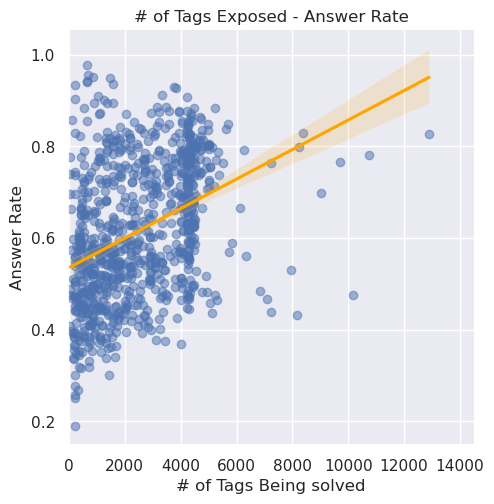

In [27]:
tag_groupby = df.groupby('KnowledgeTag').agg({
    'userID': 'count',
    'answerCode': percentile
})
g = sns.lmplot(
    data=tag_groupby,
    x='userID',
    y='answerCode',
    scatter_kws={'alpha':0.5},
    line_kws={"color": "orange"}
)
g.set_xlabels('# of Tags Being solved')
g.set_ylabels('Answer Rate')
g.set(xlim=(-30, 14500))

ax = plt.gca()
ax.set_title('# of Tags Exposed - Answer Rate');

### KnowledgeTag에 숨겨진 의미(분류체계)

#### main_cate_testID와 관계
- 없는거 같음

In [101]:
klt_groupby = df.groupby(['main_cate_testID','KnowledgeTag'],as_index=False).size()
klt_groupby.sort_values('KnowledgeTag')

,main_cate_testID,KnowledgeTag,size
667,8,23,1800
668,8,24,358
669,8,25,92
670,8,26,2432
671,8,30,539
...,...,...,...
295,4,11253,4282
296,4,11265,454
297,4,11269,2417
298,4,11270,261


In [113]:
klt_groupby.groupby('main_cate_testID')["KnowledgeTag"].nunique()

main_cate_testID
1     64
2     70
3     85
4     81
5     98
6     93
7    176
8    150
9     96
Name: KnowledgeTag, dtype: int64

#### assessmentItemID와의 관계
- assessmentItemID 하나당 Tag가 하나씩 붙는다
- 하나의 Tag가 여러개의 assessmentItemID에 붙는다

In [127]:
klt_groupby = df.groupby(['assessmentItemID','KnowledgeTag'],as_index=False).size()
klt_groupby.sort_values('KnowledgeTag')

,assessmentItemID,KnowledgeTag,size
8471,A080078003,23,92
8472,A080078004,23,92
8473,A080078005,23,92
8465,A080077005,23,358
8464,A080077004,23,358
...,...,...,...
3103,A040009006,11269,272
3099,A040009002,11269,272
3130,A040014004,11270,261
3106,A040010003,11271,261


In [139]:
## 시험지 내 문제 번호에 따른 정답률도 구해보자
df['assessmentItemID'].str[-2:].unique()

array(['01', '02', '03', '04', '05', '07', '06', '08', '09', '10', '11',
       '12', '13'], dtype=object)

In [133]:
tmp = klt_groupby.groupby('KnowledgeTag')['assessmentItemID']
tmp.get_group(26)

8477    A080079001
8478    A080079002
8479    A080079003
8480    A080079004
8484    A080079008
8485    A080080001
8486    A080080002
8487    A080080003
8488    A080080004
8489    A080080005
8490    A080080006
8492    A080080008
Name: assessmentItemID, dtype: object